In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold
import sklearn.ensemble as ske
from sklearn.linear_model import LogisticRegressionCV
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasRegressor
from itertools import cycle
from sklearn.model_selection import KFold

LISTINGSFILE = 'listings_London.csv'
#выбор нескольких чич, которые очевидны для прогнозирования цены листинга
cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

df = pd.read_csv(LISTINGSFILE, usecols=cols)


/Applications/anaconda/envs/python_coursers/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda/envs/python_coursers/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using Theano backend.


In [2]:
df

,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,Haringey,Private room,1,1.0,1.0,$30.00,12,17,91.0,f,flexible,1.42
1,Haringey,Entire home/apt,4,2.0,2.0,$150.00,0,0,NaN,t,strict,NaN
2,Southwark,Entire home/apt,4,2.0,2.0,$87.00,1,11,91.0,f,moderate,6.23
3,Southwark,Entire home/apt,6,4.0,3.0,$100.00,0,3,100.0,t,moderate,0.12
4,Kensington and Chelsea,Private room,2,1.0,1.0,$35.00,0,33,97.0,f,strict,1.94
5,Hackney,Entire home/apt,3,1.0,2.0,$118.00,26,22,93.0,f,flexible,1.80
6,Merton,Entire home/apt,3,1.0,1.0,$75.00,11,18,93.0,f,strict,1.17
7,Camden,Entire home/apt,2,1.0,1.0,$100.00,0,7,100.0,t,moderate,1.67
8,Camden,Private room,2,1.0,1.0,$55.00,30,0,NaN,f,flexible,NaN
9,Hackney,Entire home/apt,4,1.0,2.0,$80.00,0,5,96.0,f,flexible,0.35


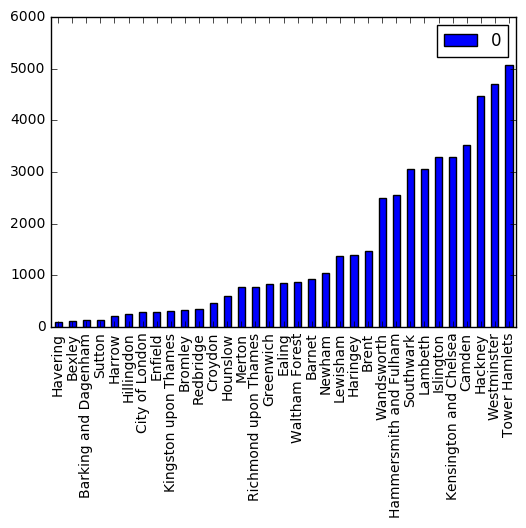

In [3]:
nb_counts = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

In [4]:
#удаление строк с  'плохими' значениями 
df['reviews_per_month'].fillna(0, inplace=True)
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

In [5]:
df = df[df.bedrooms == 1]
#удаление $ для работы с ценой
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)

In [6]:
# замена boolean на 1 и 0
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns

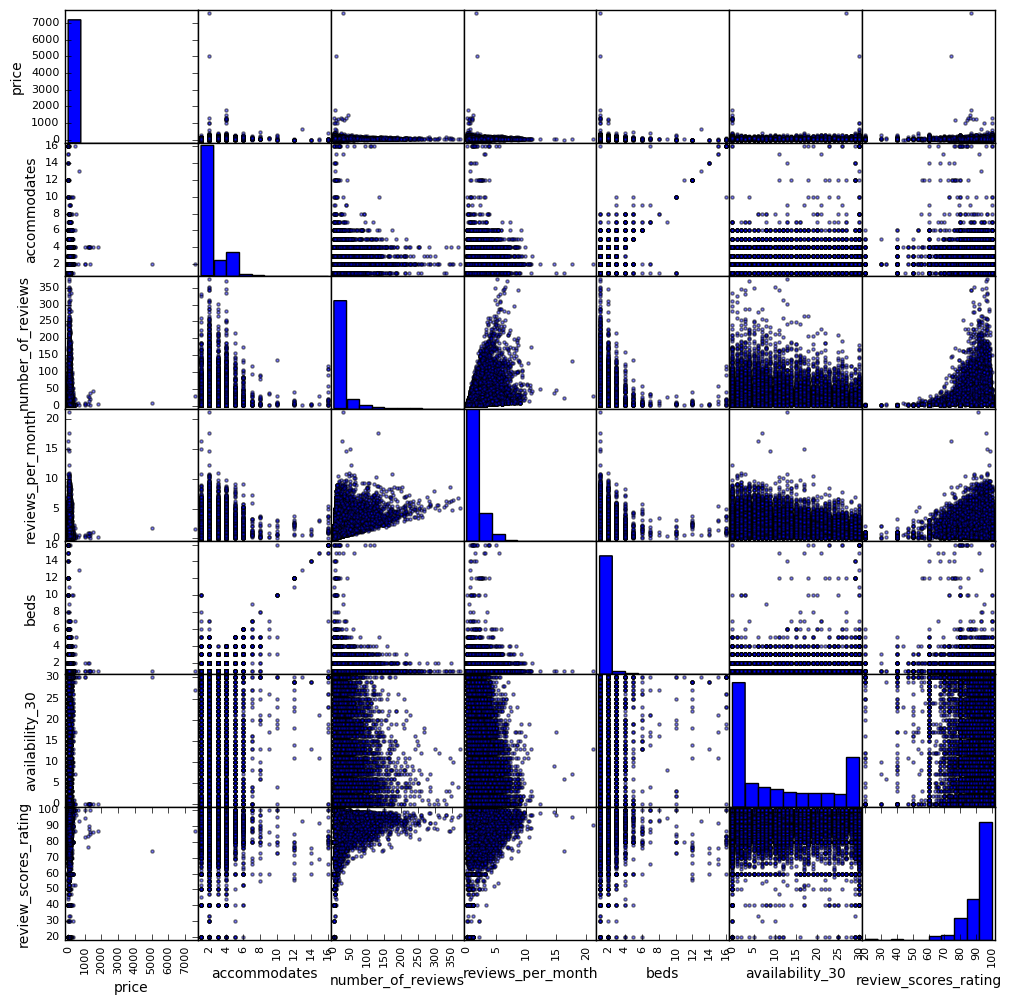

In [7]:
# выбираем независимые фичи для просмотра, можем ли выкинуть еще что нибудь
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='blue')

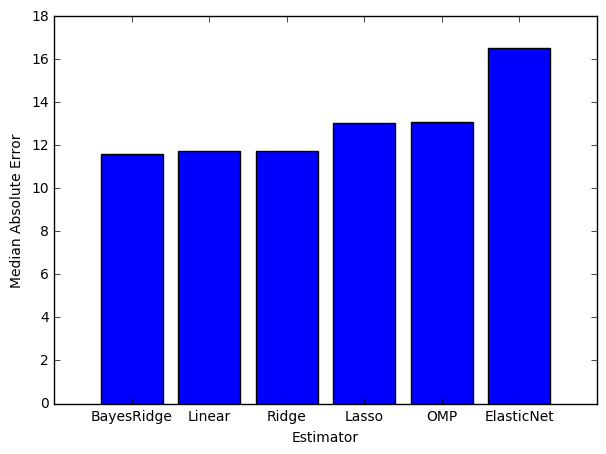

In [8]:
# сравним 6 линейных моделей по Median Absolute Error
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [9]:
# выбрали лин рег

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

Mean squared error: 1054.84
Variance score: 0.44


In [ ]:
clf = SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_train, y_train) 

In [10]:
print("error price: %.2f" % this_err)

error price: 13.07


Нейросеть для всей базы

In [11]:
x = alldata.values[:, 0:12]
y = alldata.values[:, 6]

In [12]:
# define base mode
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=12, init='normal', activation='relu'))
    model.add(Dense(50, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [13]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=30, batch_size=5, verbose=0)

In [ ]:
#kfold = StratifiedKFold(n_splits=12, random_state=seed)
results = cross_val_score(estimator, x, y, cv=None, scoring='neg_mean_squared_error', n_jobs=1) * -1
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
clf = SVC(kernel='linear', C=1).fit(x, y)
clf.score(x, y) 

In [161]:
# ограничим количество параметров
n_est = 100

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_

/Applications/anaconda/envs/python_coursers/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Applications/anaconda/envs/python_coursers/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Applications/anaconda/envs/python_coursers/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Applications/anaconda/envs/python_coursers/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed t

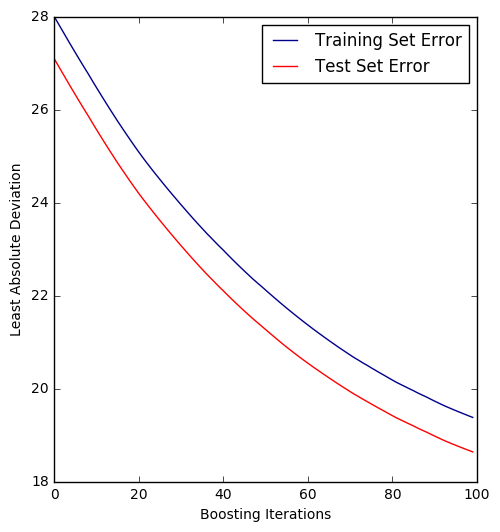

In [162]:
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

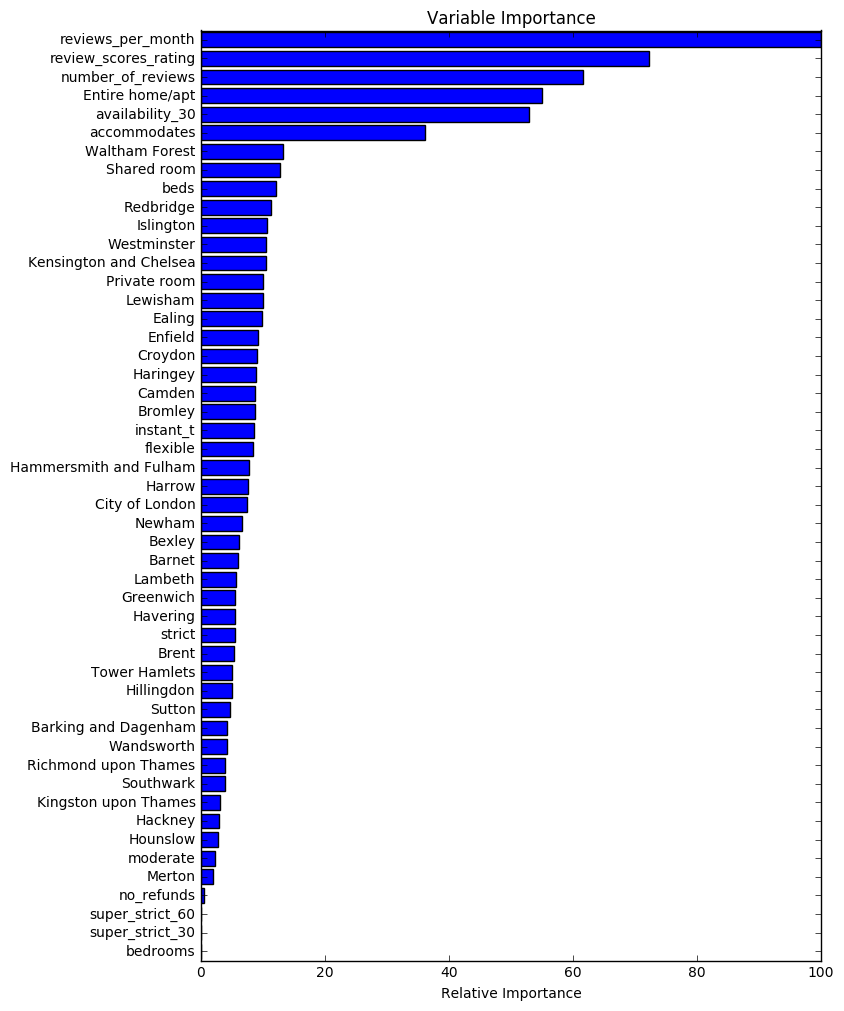

In [61]:
# какие фичи были наиболее полезными в прогнозировании цены
feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')